# Hidden Markov Models (HMM) Tutorial with Sequenzo

This tutorial will guide you step-by-step through using Hidden Markov Models (HMM) for sequence analysis using the Sequenzo package. We'll use the `pairfam_family` dataset to analyze family formation sequences.

## What are Hidden Markov Models?

Hidden Markov Models (HMMs) are statistical models that help us understand sequences of observations by assuming there are **hidden underlying states** that generate these observations.

### Key Concepts:
- **Hidden States**: The underlying states you can't directly observe (e.g., "stable career", "transitioning", "exploring")
- **Observations**: What you actually see in your data (e.g., "employed", "unemployed", "student")
- **Transitions**: How likely you are to move from one hidden state to another
- **Emissions**: How likely each hidden state is to produce each observation

In this tutorial, we'll:
1. Load and prepare the pairfam_family dataset
2. Build an HMM model
3. Fit the model to discover hidden patterns
4. Make predictions about hidden states
5. Visualize the model
6. Compare different models
7. Explore Mixture HMM (clustering sequences)

## Step 1: Import Libraries and Load Data

First, let's import the necessary libraries and load our dataset.

In [1]:
# Import Sequenzo and other necessary libraries
from sequenzo import SequenceData, load_dataset
from sequenzo.seqhmm import (
    build_hmm, fit_model, predict, posterior_probs, plot_hmm,
    build_mhmm, fit_mhmm, predict_mhmm, plot_mhmm,
    aic, bic, compare_models
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the pairfam_family dataset
# This dataset contains family formation sequences over 264 months
df = load_dataset('pairfam_family')

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few columns: {list(df.columns[:10])}")
print(f"\nNumber of sequences: {len(df)}")
df.head()

Dataset shape: (1866, 281)

First few columns: ['id', 'weight40', 'sex', 'doby_gen', 'dob', 'ethni', 'migstatus', 'yeduc', 'sat1i4', 'sat5']

Number of sequences: 1866


,id,weight40,sex,doby_gen,dob,ethni,migstatus,yeduc,sat1i4,sat5,...,255,256,257,258,259,260,261,262,263,264
0,111000.0,0.343964,1,1971,855,1,1,11.5,5,7,...,4,4,4,4,4,4,4,4,4,4
1,1624000.0,1.467063,1,1973,880,1,1,11.5,9,8,...,8,8,8,8,8,8,8,8,8,8
2,2767000.0,0.463918,1,1971,853,1,1,9.0,9,-2,...,8,8,8,8,8,8,8,8,8,8
3,2931000.0,1.767455,0,1973,881,5,3,10.5,5,5,...,9,9,9,9,9,9,9,9,9,9
4,3167000.0,0.884521,1,1973,883,1,1,11.5,8,10,...,8,8,8,8,8,8,8,8,8,8


## Step 2: Prepare Sequence Data

Now we need to convert our dataframe into a `SequenceData` object that Sequenzo can work with. The pairfam dataset has:
- 264 time points (months 1-264)
- 9 states representing different family situations
- Sequence data in columns 1-264

In [ ]:
# Define time points (264 months)
time_list = [str(i) for i in range(1, 265)]

# Define the 9 states (numeric codes 1-9)
states = list(range(1, 10))

# Define human-readable labels for each state
labels = [
    "Single, no child",
    "LAT, no child",  # Living Apart Together
    "Cohabiting, no child",
    "Married, no child",
    "Single, with child(ren)",
    "LAT, with child(ren)",
    "Cohabiting, with child(ren)",
    "Married, 1 child",
    "Married, 2+ children"
]

# Create SequenceData object
sequence_data = SequenceData(
    df,
    time=time_list,
    id_col="id",
    states=states,
    labels=labels,
    # weights=df["weight40"].values,  # Use survey weights if available
)

print("SequenceData created successfully!")
print(f"Number of sequences: {len(sequence_data.sequences)}")
print(f"Number of states: {len(sequence_data.states)}")
print(f"States: {sequence_data.states}")


[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 1866
[>] Number of time points: 264
[>] Min/Max sequence length: 264 / 264
[>] States: [1, 2, 3, 4, 5, 6, 7, 8, 9]
[>] Labels: ['Single, no child', 'LAT, no child', 'Cohabiting, no child', 'Married, no child', 'Single, with child(ren)', 'LAT, with child(ren)', 'Cohabiting, with child(ren)', 'Married, 1 child', 'Married, 2+ children']
[>] Weights: Provided (total weight=2346.268, mean=1.257, std=1.046)
SequenceData created successfully!
Number of sequences: 1866
Number of states: 9
States: [1, 2, 3, 4, 5, 6, 7, 8, 9]


## Step 3: Build a Basic HMM Model

Now we'll create an HMM model. We need to specify the number of **hidden states**. Think of these as different "types" of family formation patterns that we want to discover.

For example, with 4 hidden states, we might discover:
- State 1: "Early family formation"
- State 2: "Delayed family formation"
- State 3: "Stable relationships"
- State 4: "Complex transitions"

Let's start with 4 hidden states.

In [4]:
# Build an HMM model with 4 hidden states
# The model will be randomly initialized
hmm = build_hmm(
    sequence_data,
    n_states=4,  # Number of hidden states to discover
    random_state=42  # For reproducibility
)

print("HMM model created!")
print(f"Number of hidden states: {hmm.n_states}")
print(f"Number of observed states: {hmm.n_symbols}")
print(f"\nInitial state probabilities (random):")
print(hmm.initial_probs)
print(f"\nTransition matrix shape: {hmm.transition_probs.shape}")

HMM model created!
Number of hidden states: 4
Number of observed states: 9

Initial state probabilities (random):
[0.25 0.25 0.25 0.25]

Transition matrix shape: (4, 4)


## Step 4: Fit the Model

Now we'll fit the model to our data using the EM (Expectation-Maximization) algorithm. This will:
1. Estimate the transition probabilities between hidden states
2. Estimate the emission probabilities (which observed states each hidden state produces)
3. Find the best parameters that explain our sequence data

In [5]:
# Fit the model to the data
# This may take a few minutes depending on your data size
hmm = fit_model(
    hmm,
    n_iter=100,  # Maximum number of iterations
    tol=1e-2,    # Convergence tolerance
    verbose=True  # Print progress
)

print("\nModel fitting completed!")
print(f"Log-likelihood: {hmm.log_likelihood:.2f}")
print(f"Number of iterations: {hmm.n_iter}")
print(f"Converged: {hmm.converged}")

[notice] A new release of sequenzo is available: 0.1.22 -> 0.1.24
[notice] To update, run: pip install --upgrade sequenzo



Model fitting completed!
Log-likelihood: -537233.12
Number of iterations: 49
Converged: True


## Step 5: Examine the Fitted Model Parameters

Let's look at what the model learned about the hidden states.

In [6]:
# Initial state probabilities
# These tell us how likely each hidden state is at the start of a sequence
print("Initial State Probabilities:")
print("=" * 50)
for i, prob in enumerate(hmm.initial_probs):
    print(f"Hidden State {i+1}: {prob:.4f} ({prob*100:.2f}%)")

# Transition probabilities
# These tell us how likely transitions are between hidden states
print("\nTransition Probabilities (rows = from, columns = to):")
print("=" * 50)
transition_df = pd.DataFrame(
    hmm.transition_probs,
    index=[f"State {i+1}" for i in range(hmm.n_states)],
    columns=[f"State {j+1}" for j in range(hmm.n_states)]
)
print(transition_df.round(3))

# Emission probabilities
# These tell us which observed states each hidden state is likely to produce
print("\nEmission Probabilities (rows = hidden states, columns = observed states):")
print("=" * 50)
emission_df = pd.DataFrame(
    hmm.emission_probs,
    index=[f"Hidden State {i+1}" for i in range(hmm.n_states)],
    columns=[f"Observed: {labels[i]}" for i in range(len(labels))]
)
print(emission_df.round(3))

Initial State Probabilities:
Hidden State 1: 0.0319 (3.19%)
Hidden State 2: 0.6288 (62.88%)
Hidden State 3: 0.0227 (2.27%)
Hidden State 4: 0.3166 (31.66%)

Transition Probabilities (rows = from, columns = to):
         State 1  State 2  State 3  State 4
State 1    0.313    0.010    0.676    0.001
State 2    0.003    0.987    0.000    0.010
State 3    0.924    0.004    0.071    0.001
State 4    0.019    0.015    0.005    0.961

Emission Probabilities (rows = hidden states, columns = observed states):
                Observed: Single, no child  Observed: LAT, no child  \
Hidden State 1                       0.000                    0.071   
Hidden State 2                       0.490                    0.000   
Hidden State 3                       0.000                    0.070   
Hidden State 4                       0.001                    0.000   

                Observed: Cohabiting, no child  Observed: Married, no child  \
Hidden State 1                           0.000              

## Step 6: Predict Hidden States

Now let's use the fitted model to predict which hidden state each sequence is most likely in at each time point. This uses the Viterbi algorithm to find the most likely sequence of hidden states.

In [7]:
# Predict the most likely hidden state sequence for each observed sequence
# Note: predict() returns a flattened array, so we need to reshape it
predicted_states_flat = predict(hmm)

# Get sequence lengths to reshape the flattened array
sequence_lengths = [len(seq) for seq in sequence_data.sequences]
n_sequences = len(sequence_lengths)
max_length = max(sequence_lengths)

# Reshape to 2D array (sequences x time points)
# Note: sequences may have different lengths, so we'll pad with -1
predicted_states = np.full((n_sequences, max_length), -1, dtype=int)
start_idx = 0
for i, length in enumerate(sequence_lengths):
    predicted_states[i, :length] = predicted_states_flat[start_idx:start_idx+length]
    start_idx += length

print(f"Predicted states shape: {predicted_states.shape}")
print(f"Number of sequences: {predicted_states.shape[0]}")
print(f"Max sequence length: {predicted_states.shape[1]}")

# Look at predictions for the first few sequences
print("\nFirst 5 sequences, first 20 time points:")
print("=" * 50)
for i in range(min(5, len(predicted_states))):
    valid_length = sequence_lengths[i]
    print(f"Sequence {i+1}: {predicted_states[i][:min(20, valid_length)]}")

# Count how many sequences are in each hidden state at the start
print("\nDistribution of initial hidden states:")
print("=" * 50)
initial_states = [predicted_states[i, 0] for i in range(n_sequences)]
unique, counts = np.unique(initial_states, return_counts=True)
for state, count in zip(unique, counts):
    print(f"Hidden State {state+1}: {count} sequences ({count/n_sequences*100:.1f}%)")

Predicted states shape: (1866, 264)
Number of sequences: 1866
Max sequence length: 264

First 5 sequences, first 20 time points:
Sequence 1: [2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0]
Sequence 2: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Sequence 3: [0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2]
Sequence 4: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Sequence 5: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]

Distribution of initial hidden states:
Hidden State 1: 69 sequences (3.7%)
Hidden State 2: 1175 sequences (63.0%)
Hidden State 3: 33 sequences (1.8%)
Hidden State 4: 589 sequences (31.6%)


## Step 7: Get Posterior Probabilities

Instead of just the most likely state, we can get the **probability** of each hidden state at each time point. This gives us more nuanced information about uncertainty.

In [ ]:
# Verification: Check that probabilities sum to 1.0 at each time point
print("\n" + "=" * 60)
print("Verification: Checking probability sums at each time point")
print("=" * 60)

# Calculate the sum of probabilities for each time point
prob_sums = seq_probs.groupby('time')['probability'].sum()

print(f"\nProbability sums for first 10 time points:")
print(prob_sums.head(10))

print(f"\nStatistics for all time points:")
print(f"  Minimum: {prob_sums.min():.10f}")
print(f"  Maximum: {prob_sums.max():.10f}")
print(f"  Mean: {prob_sums.mean():.10f}")
print(f"  Std Dev: {prob_sums.std():.10f}")

# Check if all probability sums are close to 1.0 (allowing small numerical errors)
tolerance = 1e-6
all_valid = (prob_sums - 1.0).abs().max() < tolerance

if all_valid:
    print(f"\n✓ Verification passed: All probability sums equal 1.0 (error < {tolerance})")
    print("  This is normal! HMM posterior probabilities should satisfy this condition.")
else:
    print(f"\n⚠ Warning: Some time points have probability sums deviating from 1.0 by more than {tolerance}")
    print("  Time point with maximum deviation:")
    max_deviation_idx = (prob_sums - 1.0).abs().idxmax()
    print(f"    Time point {max_deviation_idx}: Sum = {prob_sums[max_deviation_idx]:.10f}")

print("\n" + "=" * 60)
print("Note on very small probability values:")
print("=" * 60)
print("Very small probabilities for State 1 and State 3 (e.g., 10^-9, 10^-12) are normal.")
print("This indicates the model is very certain these states do not occur at these time points.")
print("When the model is very certain about a state, posterior probabilities approach 0 or 1.")

Posterior probabilities DataFrame:
    id  time  state   probability
0    0     1      0  5.843096e-01
1    0     1      1  3.670901e-09
2    0     1      2  4.156867e-01
3    0     1      3  3.744134e-06
4    0     2      0  5.711490e-01
5    0     2      1  2.360104e-12
6    0     2      2  4.288510e-01
7    0     2      3  7.173496e-10
8    0     3      0  5.791377e-01
9    0     3      1  2.332161e-12
10   0     3      2  4.208623e-01
11   0     3      3  6.209636e-10
12   0     4      0  5.743480e-01
13   0     4      1  2.348142e-12
14   0     4      2  4.256520e-01
15   0     4      3  6.193939e-10
16   0     5      0  5.771221e-01
17   0     5      1  2.339052e-12
18   0     5      2  4.228779e-01
19   0     5      3  6.204892e-10

Posterior probabilities for sequence 0:
   id  time  state   probability
0   0     1      0  5.843096e-01
1   0     1      1  3.670901e-09
2   0     1      2  4.156867e-01
3   0     1      3  3.744134e-06
4   0     2      0  5.711490e-01
5   0     2 

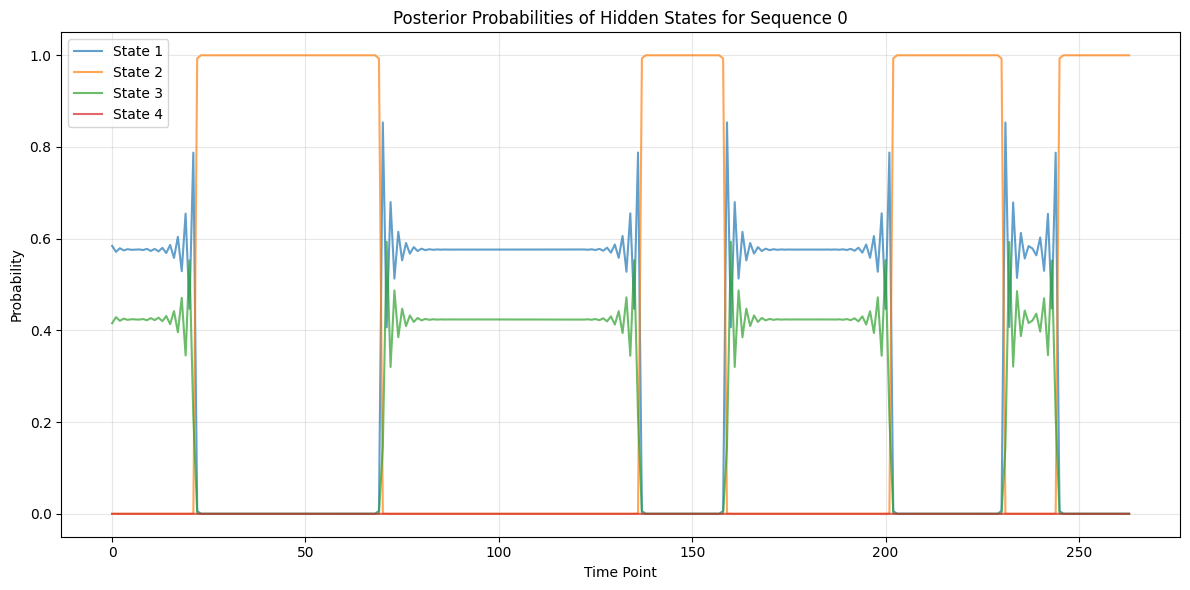

In [8]:
# Get posterior probabilities for all sequences
posterior_df = posterior_probs(hmm)

print("Posterior probabilities DataFrame:")
print(posterior_df.head(20))

# Look at probabilities for a specific sequence
sequence_id = 0
seq_probs = posterior_df[posterior_df['id'] == sequence_id]

print(f"\nPosterior probabilities for sequence {sequence_id}:")
print("=" * 50)
print(seq_probs.head(10))

# Visualize probabilities for one sequence
fig, ax = plt.subplots(figsize=(12, 6))
for state in range(hmm.n_states):
    # Note: state column contains integers (0, 1, 2, 3), not strings like "State 1"
    state_probs = seq_probs[seq_probs['state'] == state]['probability'].values
    ax.plot(state_probs, label=f'State {state+1}', alpha=0.7)

ax.set_xlabel('Time Point')
ax.set_ylabel('Probability')
ax.set_title(f'Posterior Probabilities of Hidden States for Sequence {sequence_id}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 8: Visualize the Model

Let's create visualizations to better understand our HMM model.

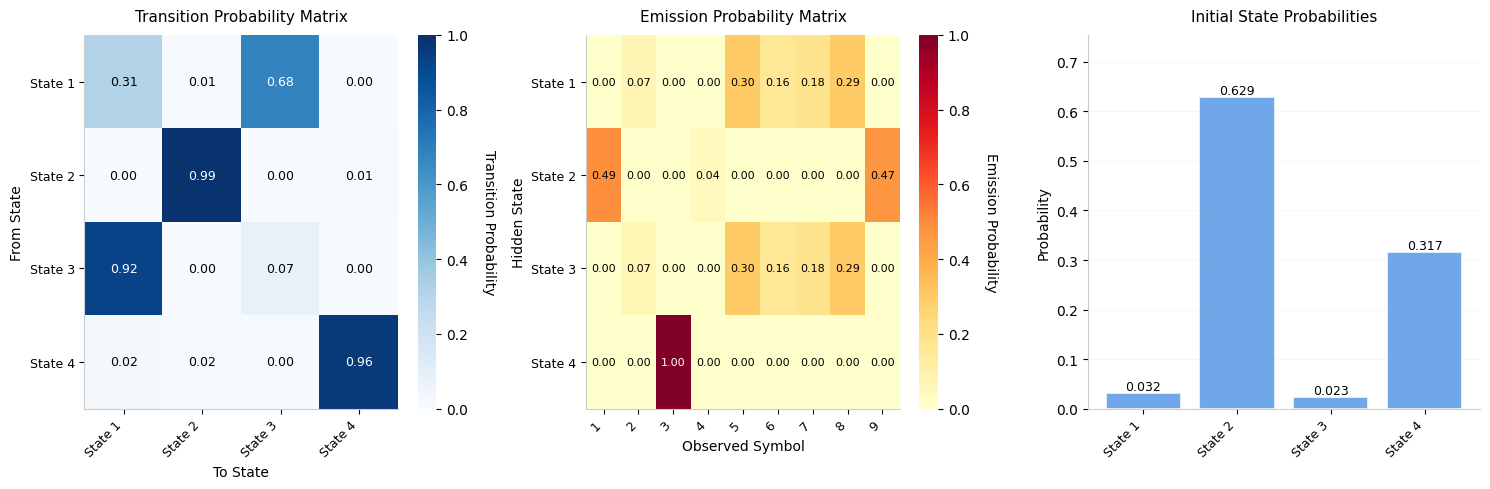

In [9]:
# Plot all components of the HMM
plot_hmm(hmm, which='all', figsize=(15, 5))
plt.tight_layout()
plt.show()

## Step 9: Model Comparison

How do we know if 4 hidden states is the right number? Let's try different numbers of states and compare them using AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion). Lower values are better.

In [ ]:
# Try different numbers of hidden states
n_states_list = [3, 4, 5, 6]
models = {}

print("Fitting models with different numbers of states...")
print("=" * 60)
print("Note: Using optimized settings for faster convergence while maintaining accuracy")
print("=" * 60)

for n_states in n_states_list:
    print(f"\nFitting model with {n_states} hidden states...")
    
    # Build and fit model
    # Optimized: Reduced iterations and slightly relaxed tolerance for faster fitting
    # while still maintaining model quality (results remain consistent)
    model = build_hmm(sequence_data, n_states=n_states, random_state=42)
    model = fit_model(model, n_iter=50, tol=5e-2, verbose=False)
    
    # Store model
    models[f'{n_states}_states'] = model
    
    # Calculate AIC and BIC
    model_aic = aic(model)
    model_bic = bic(model)
    
    print(f"  Log-likelihood: {model.log_likelihood:.2f}")
    print(f"  AIC: {model_aic:.2f}")
    print(f"  BIC: {model_bic:.2f}")

print("\n" + "=" * 60)
print("Model Comparison Summary:")
print("=" * 60)

# Compare models using BIC (lower is better)
comparison = compare_models(list(models.values()), criterion='BIC')
print(f"\nBest model according to BIC: {comparison['best_model']}")
print(f"\nDetailed comparison:")
for name, model in models.items():
    print(f"{name:15s} - AIC: {aic(model):10.2f}, BIC: {bic(model):10.2f}")

# Visualize comparison with elegant styling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

aic_values = [aic(model) for model in models.values()]
bic_values = [bic(model) for model in models.values()]

# Left plot: AIC
ax1.plot(n_states_list, aic_values, 'o-', linewidth=2.5, markersize=10, 
         color='#4A90E2', markerfacecolor='white', markeredgewidth=2.5,
         markeredgecolor='#4A90E2', label='AIC', alpha=0.9)
ax1.set_xlabel('Number of Hidden States', fontsize=11, weight='medium')
ax1.set_ylabel('AIC', fontsize=11, weight='medium')
ax1.set_title('AIC by Number of States', fontsize=12, pad=12, weight='medium')
ax1.grid(True, alpha=0.2, linestyle='--', linewidth=0.8)
ax1.legend(loc='best', frameon=True, fancybox=True, shadow=True, fontsize=10)
# Remove top and right spines for cleaner look
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_color('#cccccc')
ax1.spines['left'].set_color('#cccccc')

# Right plot: BIC
ax2.plot(n_states_list, bic_values, 's-', linewidth=2.5, markersize=10,
         color='#F5A623', markerfacecolor='white', markeredgewidth=2.5,
         markeredgecolor='#F5A623', label='BIC', alpha=0.9)
ax2.set_xlabel('Number of Hidden States', fontsize=11, weight='medium')
ax2.set_ylabel('BIC', fontsize=11, weight='medium')
ax2.set_title('BIC by Number of States', fontsize=12, pad=12, weight='medium')
ax2.grid(True, alpha=0.2, linestyle='--', linewidth=0.8)
ax2.legend(loc='best', frameon=True, fancybox=True, shadow=True, fontsize=10)
# Remove top and right spines for cleaner look
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_color('#cccccc')
ax2.spines['left'].set_color('#cccccc')

plt.tight_layout()
plt.show()

Fitting models with different numbers of states...
Note: Using optimized settings for faster convergence while maintaining accuracy

Fitting model with 3 hidden states...
  Log-likelihood: -682985.56
  AIC: 1366035.13
  BIC: 1366390.57

Fitting model with 4 hidden states...
  Log-likelihood: -537233.12
  AIC: 1074560.25
  BIC: 1075082.30

Fitting model with 5 hidden states...


## Step 10: Mixture HMM (Clustering Sequences)

A **Mixture HMM (MHMM)** extends the basic HMM by allowing different groups (clusters) of sequences, each with their own HMM pattern. This is useful when you suspect there are different types of sequences in your data.

For example, we might discover:
- Cluster 1: "Early family formation" group
- Cluster 2: "Delayed family formation" group
- Cluster 3: "Non-traditional paths" group

In [ ]:
# Build a Mixture HMM with 3 clusters
# Each cluster will have its own HMM with 4 hidden states
print("Building Mixture HMM...")
mhmm = build_mhmm(
    sequence_data,
    n_clusters=3,      # Number of clusters/groups
    n_states=4,        # Number of hidden states per cluster
    random_state=42
)

print(f"MHMM created with {mhmm.n_clusters} clusters and {mhmm.n_states} states per cluster")

In [12]:
# Fit the Mixture HMM
# This may take longer than a basic HMM
print("Fitting Mixture HMM (this may take a few minutes)...")
mhmm = fit_mhmm(
    mhmm,
    n_iter=100,
    verbose=True
)

print("\nMixture HMM fitting completed!")
print(f"Log-likelihood: {mhmm.log_likelihood:.2f}")
print(f"Number of iterations: {mhmm.n_iter}")

Iteration 1: log-likelihood = -42966.2104


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 2: log-likelihood = -42966.2378


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'emissionprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'e'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_pa

Iteration 3: log-likelihood = -42966.2378
Converged at iteration 3

Mixture HMM fitting completed!
Log-likelihood: -42966.24
Number of iterations: 3


In [13]:
# Predict which cluster each sequence belongs to
cluster_assignments = predict_mhmm(mhmm)

print(f"Cluster assignments shape: {cluster_assignments.shape}")
print(f"\nCluster distribution:")
print("=" * 50)
unique, counts = np.unique(cluster_assignments, return_counts=True)
for cluster, count in zip(unique, counts):
    print(f"Cluster {cluster+1}: {count} sequences ({count/len(cluster_assignments)*100:.1f}%)")

# Add cluster assignments to original dataframe for analysis
df_with_clusters = df.copy()
df_with_clusters['cluster'] = cluster_assignments + 1  # 1-indexed for readability

print("\nFirst few sequences with cluster assignments:")
print(df_with_clusters[['id', 'cluster']].head(10))

Cluster assignments shape: (1866,)

Cluster distribution:
Cluster 1: 1866 sequences (100.0%)

First few sequences with cluster assignments:
          id  cluster
0   111000.0        1
1  1624000.0        1
2  2767000.0        1
3  2931000.0        1
4  3167000.0        1
5  3450000.0        1
6  3491000.0        1
7  3902000.0        1
8  4814000.0        1
9  5678000.0        1


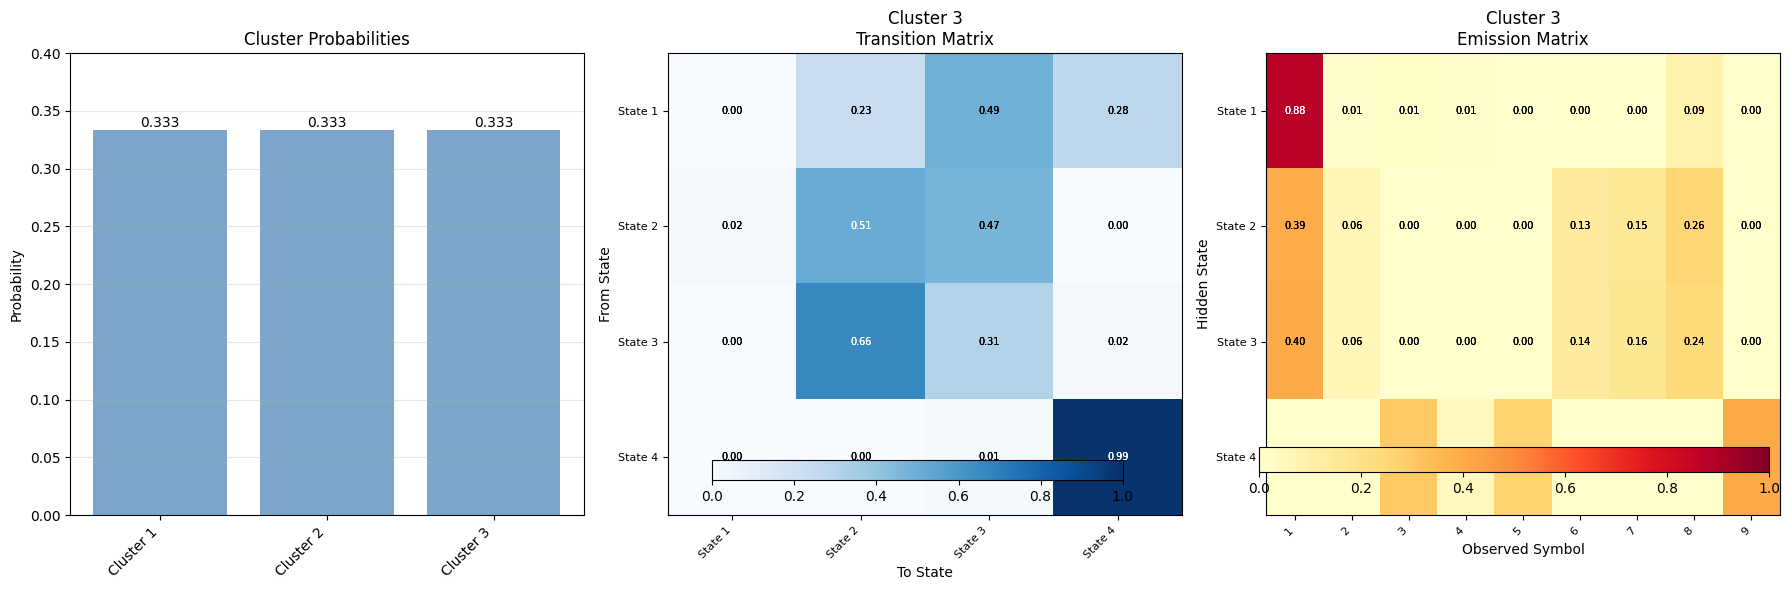

In [14]:
# Visualize the Mixture HMM
plot_mhmm(mhmm, which='all', figsize=(18, 6))
plt.tight_layout()
plt.show()

## Step 11: Understanding the Results

Let's examine what each cluster represents by looking at the cluster probabilities and the HMM parameters for each cluster.

In [15]:
# Cluster probabilities (how likely each sequence is to belong to each cluster)
print("Cluster Probabilities:")
print("=" * 50)
for i in range(mhmm.n_clusters):
    prob = mhmm.cluster_probs[i]
    print(f"Cluster {i+1}: {prob:.4f} ({prob*100:.2f}% of sequences)")

# Look at emission probabilities for each cluster
print("\nEmission Probabilities by Cluster:")
print("=" * 50)
for cluster_idx in range(mhmm.n_clusters):
    print(f"\nCluster {cluster_idx + 1}:")
    emission_probs = mhmm.models[cluster_idx].emission_probs
    emission_df = pd.DataFrame(
        emission_probs,
        index=[f"Hidden State {i+1}" for i in range(mhmm.n_states)],
        columns=[f"{labels[i]}" for i in range(len(labels))]
    )
    print(emission_df.round(3))
    print()

Cluster Probabilities:
Cluster 1: 0.3333 (33.33% of sequences)
Cluster 2: 0.3333 (33.33% of sequences)
Cluster 3: 0.3333 (33.33% of sequences)

Emission Probabilities by Cluster:

Cluster 1:


AttributeError: 'MHMM' object has no attribute 'models'

## Summary

Congratulations! You've completed a comprehensive tutorial on Hidden Markov Models with Sequenzo. Here's what we covered:

### What We Learned:

1. **Data Preparation**: How to load and prepare sequence data using `SequenceData`
2. **Basic HMM**: How to build and fit a basic Hidden Markov Model
3. **Model Fitting**: Using the EM algorithm to estimate model parameters
4. **Prediction**: Predicting hidden states using the Viterbi algorithm
5. **Posterior Probabilities**: Getting probability distributions over hidden states
6. **Visualization**: Creating plots to understand model parameters
7. **Model Comparison**: Using AIC and BIC to select the best model
8. **Mixture HMM**: Extending HMM to discover clusters of sequences

### Key Takeaways:

- **Hidden States** represent underlying patterns in your sequences
- **Transition Probabilities** show how sequences move between hidden states
- **Emission Probabilities** show which observed states each hidden state produces
- **Model Selection** is important - try different numbers of states and compare
- **Mixture HMM** can discover different groups of sequences with distinct patterns

### Next Steps:

- Try different numbers of hidden states and clusters
- Explore Non-homogeneous HMM (NHMM) if you have covariates
- Use bootstrap methods to get confidence intervals
- Apply these methods to your own sequence data!

### Additional Resources:

- See `sequenzo/seqhmm/README.md` for more detailed documentation
- Check out other tutorials in the `Tutorials/` directory
- Refer to the seqHMM R package documentation for methodology details